<a href="https://colab.research.google.com/github/mrithikab/Natures-Remedy/blob/main/Another_copy_of_Untitled1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# original dataset

In [ ]:
#run this
from google.colab import files
files.upload()  # Upload kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset (replace with your dataset name)
!kaggle datasets download -d warcoder/indian-medicinal-plant-image-dataset
!unzip /content/indian-medicinal-plant-image-dataset.zip -d /content/


In [ ]:
!pip install split-folders
import splitfolders
splitfolders.ratio("/content/Medicinal plant dataset", output="/content/data-split", seed=1337, ratio=(0.8, 0.15, 0.05), group_prefix=None, move=False)

Copying files: 5945 files [00:01, 3747.57 files/s]


In [ ]:

import os
os.listdir('/content/data-split/train')




['Amruta_Balli',
 'Hibiscus',
 'Betel_Nut',
 'Ganike',
 'Avacado',
 'Brahmi',
 'Tulasi',
 'Honge',
 'Ekka',
 'Curry_Leaf',
 'Jasmine',
 'Rose',
 'Nagadali',
 'Insulin',
 'Betel',
 'Geranium',
 'Doddapatre',
 'Henna',
 'Pomegranate',
 'Neem',
 'Nithyapushpa',
 'Basale',
 'Bamboo',
 'Lemon',
 'Castor',
 'Pepper',
 'Amla',
 'Nooni',
 'Arali',
 'Pappaya',
 'Sapota',
 'Aloevera',
 'Lemon_grass',
 'Wood_sorel',
 'Mango',
 'Raktachandini',
 'Ashwagandha',
 'Mint',
 'Ashoka',
 'Gauva']

In [ ]:
#run this
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder('/content/data-split/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [ ]:
#run this
import os
import torch
import torch.nn as nn
from torchvision import models

model = models.resnet50(pretrained=True)

# Freeze early layers if needed
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(os.listdir("/content/data-split/train")))  # len() here returns number of classes

# Move model to GPU
model = model.cuda()


In [ ]:
#run this
val_dataset=datasets.ImageFolder('/content/data-split/val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Epoch [1/10], Train Loss: 2.1790, Train Accuracy: 50.69%, Val Loss: 1.0710, Val Accuracy: 77.89%
Epoch [2/10], Train Loss: 0.9167, Train Accuracy: 81.33%, Val Loss: 0.6701, Val Accuracy: 86.02%
Epoch [3/10], Train Loss: 0.6302, Train Accuracy: 86.68%, Val Loss: 0.5100, Val Accuracy: 88.73%
Epoch [4/10], Train Loss: 0.4942, Train Accuracy: 88.56%, Val Loss: 0.4318, Val Accuracy: 88.87%
Epoch [5/10], Train Loss: 0.3985, Train Accuracy: 91.08%, Val Loss: 0.3638, Val Accuracy: 91.45%
Epoch [6/10], Train Loss: 0.3397, Train Accuracy: 92.24%, Val Loss: 0.3167, Val Accuracy: 91.59%
Epoch [7/10], Train Loss: 0.2977, Train Accuracy: 93.83%, Val Loss: 0.2905, Val Accuracy: 92.91%
Epoch [8/10], Train Loss: 0.2670, Train Accuracy: 94.21%, Val Loss: 0.2704, Val Accuracy: 92.63%
Epoch [9/10], Train Loss: 0.2399, Train Accuracy: 94.76%, Val Loss: 0.2430, Val Accuracy: 93.67%
Epoch [10/10], Train Loss: 0.2228, Train Accuracy: 94.97%, Val Loss: 0.2566, Val Accuracy: 93.60%


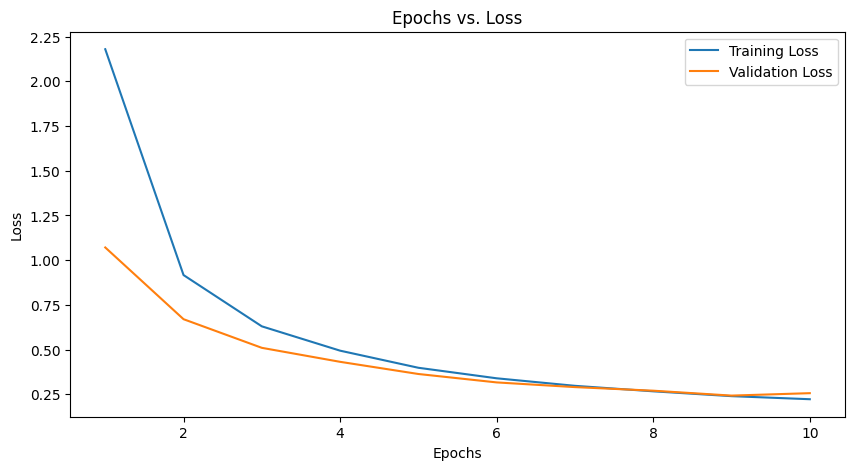

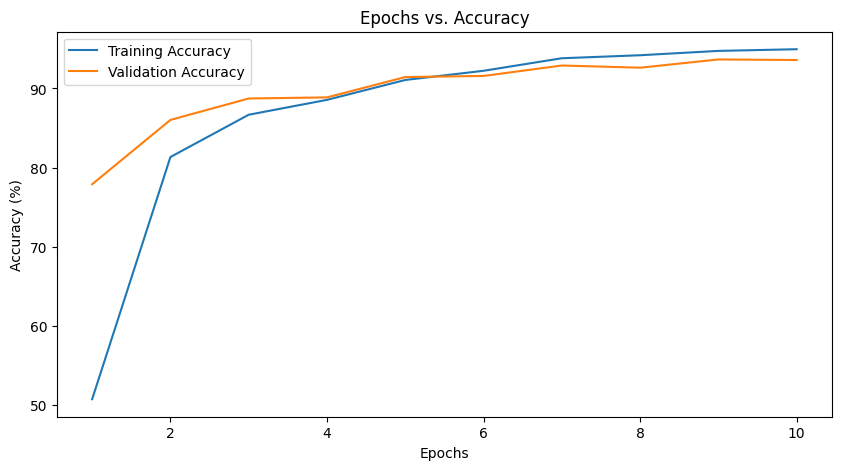

In [ ]:
#run this
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt



criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

# Lists to store metrics for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # --- Training ---
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()  # Zero out gradients
        outputs = model(inputs)
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagate
        optimizer.step()  # Update parameters

        running_loss += loss.item()  # Accumulate the loss
        _, predicted = torch.max(outputs.data, 1)  # Get predicted classes
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    # Save metrics for training
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # --- Validation ---
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in val_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total

    # Save metrics for validation
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print metrics for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

#run this
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs. Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Epochs vs. Accuracy')
plt.legend()
plt.show()



In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'plant_image_classifier.pth')

# Download the model file to local machine
from google.colab import files
files.download('plant_image_classifier.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Define the same transforms for the test set as for training and validation
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the test dataset
test_dataset = datasets.ImageFolder('/content/data-split/test', transform=test_transform)

# Create DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


<ipython-input-10-317f95fed1f1>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('plant_image_classifier.pth', map_location=torch.device('c

Classification Report:
               precision    recall  f1-score   support

 Amruta_Balli       0.80      0.89      0.84         9
     Hibiscus       0.82      1.00      0.90         9
    Betel_Nut       0.67      0.44      0.53         9
       Ganike       1.00      1.00      1.00         9
      Avacado       1.00      1.00      1.00         9
       Brahmi       1.00      1.00      1.00         9
       Tulasi       1.00      1.00      1.00         9
        Honge       1.00      1.00      1.00         9
         Ekka       1.00      0.78      0.88         9
   Curry_Leaf       0.73      0.89      0.80         9
      Jasmine       1.00      1.00      1.00         9
         Rose       1.00      1.00      1.00         9
     Nagadali       0.78      0.88      0.82         8
      Insulin       1.00      0.67      0.80         9
        Betel       1.00      0.89      0.94         9
     Geranium       1.00      0.89      0.94         9
   Doddapatre       0.80      0.67      0

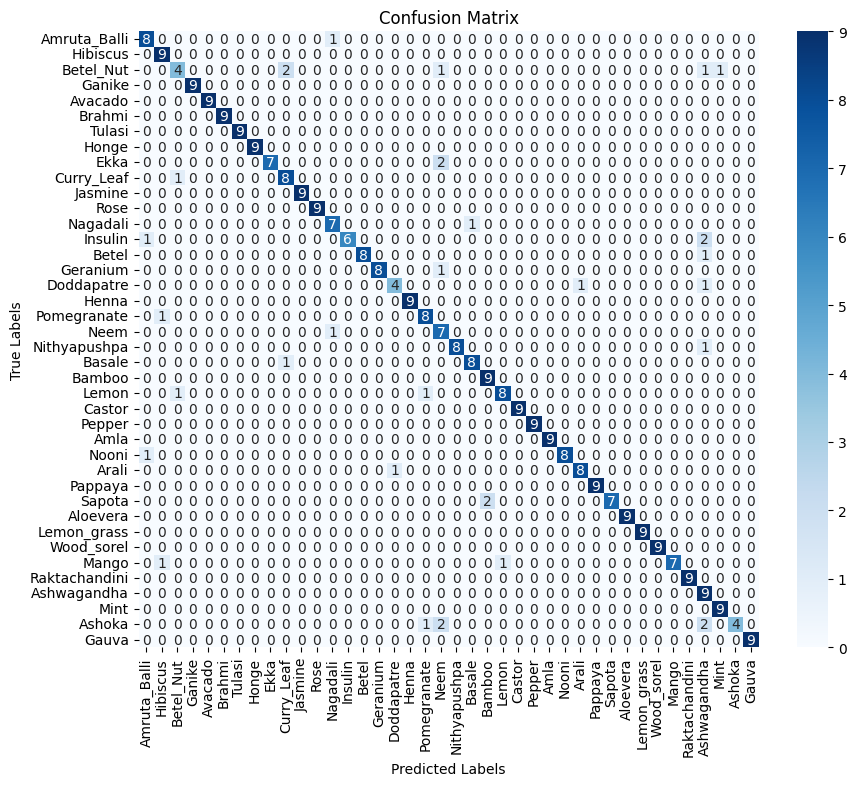

In [ ]:
from torchvision import models
class_names=['Amruta_Balli',
 'Hibiscus',
 'Betel_Nut',
 'Ganike',
 'Avacado',
 'Brahmi',
 'Tulasi',
 'Honge',
 'Ekka',
 'Curry_Leaf',
 'Jasmine',
 'Rose',
 'Nagadali',
 'Insulin',
 'Betel',
 'Geranium',
 'Doddapatre',
 'Henna',
 'Pomegranate',
 'Neem',
 'Nithyapushpa',
 'Basale',
 'Bamboo',
 'Lemon',
 'Castor',
 'Pepper',
 'Amla',
 'Nooni',
 'Arali',
 'Pappaya',
 'Sapota',
 'Aloevera',
 'Lemon_grass',
 'Wood_sorel',
 'Mango',
 'Raktachandini',
 'Ashwagandha',
 'Mint',
 'Ashoka',
 'Gauva'
]
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Put the model in evaluation mode
model = models.resnet50()  # Define the architecture
num_classes = 40  # Replace with the actual number of classes in your dataset
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)  # Adjust the final layer
model.load_state_dict(torch.load('plant_image_classifier.pth', map_location=torch.device('cpu')))
model.eval()

# Initialize lists to hold labels and predictions
all_labels = []
all_preds = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move data to GPU if available
        #inputs, labels = inputs.cuda(), labels.cuda()

        # Get model predictions
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Collect labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Generate and print the classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Evaluate the model on the test dataset
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculation during testing
    for inputs, labels in test_loader:  # Use test_loader here
        inputs, labels = inputs.cuda(), labels.cuda()  # Move data to GPU
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)  # Get class with max score
        total += labels.size(0)  # Increment total number of examples
        correct += (predicted == labels).sum().item()  # Count correct predictions

# Calculate and print test accuracy
print(f'Test Accuracy: {100 * correct / total:.2f}%')


Test Accuracy: 92.18%


In [ ]:
import torch
import torch.nn.functional as F

# Define your threshold for flagging as "Unknown"
threshold = 0.7

model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
unknown_count = 0

# Ensure no gradients are calculated during evaluation
with torch.no_grad():
    for inputs, labels in test_loader:  # Use test_loader here
        inputs, labels = inputs.cuda(), labels.cuda()  # Move data to GPU

        # Get model outputs (logits)
        outputs = model(inputs)

        # Apply softmax to get probabilities
        probabilities = F.softmax(outputs, dim=1)

        # Get the maximum probability and its corresponding class index
        max_probs, predicted = torch.max(probabilities, 1)

        # Check for each prediction if the confidence is above the threshold
        for i in range(len(max_probs)):
            if max_probs[i].item() >= threshold:
                # If confidence is high enough, treat the prediction as valid
                if predicted[i] == labels[i]:
                    correct += 1
            else:
                # If confidence is below the threshold, classify as "Unknown"
                unknown_count += 1

        total += labels.size(0)  # Increment total number of examples

# Calculate and print test accuracy and unknowns
accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')
print(f'Unknown Flagged Images: {unknown_count}/{total}')


Test Accuracy: 93.40%
Unknown Flagged Images: 35/1000


In [ ]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F

# Define your transformation for the image (same as during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size required by ResNet
    transforms.ToTensor(),  # Convert image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as per ResNet training
])

# Load a single image and apply transformations
def load_image(image_path):
    image = Image.open(image_path)  # Open the image file
    image = transform(image).unsqueeze(0)  # Apply transforms and add batch dimension
    return image

# Classify the image
def classify_single_image(model, image_path, class_names, threshold=0.7):
    model.eval()  # Set the model to evaluation mode

    # Load and preprocess the image
    image = load_image(image_path)
    image = image.cuda() if torch.cuda.is_available() else image  # Move to GPU if available

    with torch.no_grad():  # Disable gradient calculation
        # Get the model output (logits)
        outputs = model(image)

        # Apply softmax to convert logits to probabilities
        probabilities = F.softmax(outputs, dim=1)

        # Get the maximum probability and its associated class index
        max_prob, predicted_idx = torch.max(probabilities, 1)
        predicted_class = class_names[predicted_idx.item()]

        # Check if the maximum probability is above the threshold
        if max_prob.item() >= threshold:
          return predicted_class, max_prob.item()
        else:
            return "Unknown", max_prob.item()

# Example usage:
# Assuming `class_names` is a list of class labels (e.g., ['Plant1', 'Plant2', 'Plant3'])
image_path = "/content/149.jpg"  # Path to your image file
import os
path = "/content/data-split/test"
class_names=os.listdir(path)

predicted_class, confidence = classify_single_image(model, image_path, class_names, threshold=0.7)

print(f'Predicted Class: {predicted_class}, Confidence: {confidence:.2f}')


Predicted Class: Betel_Nut, Confidence: 0.96
